# Week02 Assignment by Angela Liang

In [13]:
# import necessary packages for this assignment
import pandas as pd
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt

# packages for question 2 (cholesky is for question 3)
from numpy.linalg import eigh, cholesky 
from scipy.linalg import sqrtm, inv
from scipy.optimize import minimize
import timeit

# packages for question 3 
from scipy.stats import norm
import time

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Problem 1

Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.
Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it. Vary λ∈(0,1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λ chosen.

What does this tell us about values of λ and the effect it has on the covariance matrix?

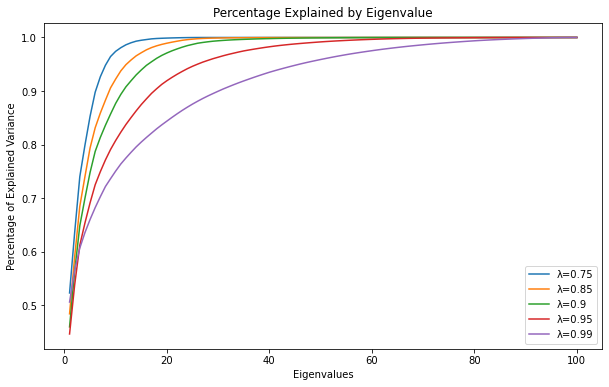

In [14]:
# First parse data 
# Then, steps for calculating exponentially weighted covariance matrix
# the variance for tomorrow is updated based on today's forcast variance and today's deviation from the mean 
# just in case, typical # trading days to calculate annualized amount is 252 

# Read data and drop the column with dates 
rets = pd.read_csv("/Users/angelaliang/Documents/fintech545/Week03/Project/DailyReturn.csv")
rets = rets.drop(columns=rets.columns[0])
rets = rets.dropna(subset=['SPY'])

# Convert InlineString columns to Float64
for column in rets.columns:
      if rets[column].dtype == 'object':
            rets[column] = pd.to_numeric(rets[column], erros='coerce')

# Function to calculate exponentially weighted covariance
def ewCovar(x, λ):
      m, n = x.shape
      w = np.empty(m)

      # Remove the mean from the series
      xm = x.mean(axis = 0)
      x = x - xm

      # Calculate weights
      for i in range(m):
            w[i] = (1-λ)*λ**(m-i)

      # Normalize weights to 1
      w /= np.sum(w)

      # Covariance calculation
      return np.dot((w*x.T),x)

# Function to calculate exponential weights
def expW(m,λ):
      w=np.empty(m)
      for i in range(m):
            w[i] = (1-λ)*λ**(m-i)
      # Normalize weights to 1
      w /= np.sum(w)
      return w

# Function to calculate percentage explained by each Eigenvalue
def PCA_pctExplained(a):
      vals=np.linalg.eigvals(a)
      vals=np.real_if_close(vals,tol=1000) # Convert complex eigenvalues to real
      vals=np.sort(vals)[::-1] # Sort eigenvalues in descending order
      total = np.sum(vals)
      out=np.empty(len(vals))
      s = 0.0
      for i in range(len(vals)):
            s+=vals[i]
            out[i]=s/total # Cumulative % of the total
      return out

# Calculate exponentially weighted covariance for different λ values
λ_values = [0.75, 0.85, 0.90, 0.95, 0.99]
pctExplained = {'λ='+str(λ): PCA_pctExplained(ewCovar(rets.values,λ)) for λ in λ_values}

# Plot the results 
plt.figure(figsize=(10,6))
for label,values in pctExplained.items():
      plt.plot(range(1,len(values)+1), values, label=label)
plt.title("Percentage Explained by Eigenvalue")
plt.xlabel('Eigenvalues')
plt.ylabel('Percentage of Explained Variance')
plt.legend()
plt.show()


## Analysis and conclusion
λ determines the rate at which the weights of past observations in the dataset decrease exponentially. When λ is closer to 1, the decay in weight for past data is slower meaning older data retians more significance, and when λ is closer to 0, the decay in weight is faster, meaning recent data are more significant. From the graph, a lower λ reaches a given level of explained variance with fewer components than a higher λ, suggesting that when less weight is given to older data, fewer components are needed to capture the same amount of variance, and vice versa. 
A higher λ will result in a smoother covariance matrix as it reflects more long-term trends and is less reactive to short-term fluctuations in the data. 
A lower λ will result in a more sensitive covariance matrix as it is more indicative of near-future movements than long-term trends. 

## Problem 2
Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice. These are core functions you will need throughout the
remainder of the class. Implement Higham’s 2002 nearest psd correlation function. Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:
```python 
n=500
sigma = fill(0.9,(n,n))
for i in 1:n
sigma[i,i]=1.0
end
sigma[1,2] = 0.7357
sigma[2,1] = 0.7357
```
Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.
Compare the results of both using the Frobenius Norm. Compare the run time between the two.
How does the run time of each function compare as N increases?
Based on the above, discuss the pros and cons of each method and when you would use each.
There is no wrong answer here, I want you to think through this and tell me what you think.


In [15]:

def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    invSD = None
    out = a.copy()

    # Calculate the correlation matrix if we got a covariance matrix
    if not np.all(np.isclose(np.diag(out), 1.0)):
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD

    # SVD, update the eigenvalue and scale
    vals, vecs = eigh(out)
    vals = np.maximum(vals, epsilon)
    T = np.diag(1.0 / np.sqrt(np.sum(vecs ** 2 * vals, axis=0)))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T

    # Add back the variance
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = invSD @ out @ invSD

    return out

def higham_nearestPSD(A, epsilon=1e-10, maxIter=100, tol=1e-5):
    n = A.shape[0]
    W = np.identity(n)
    deltaS = 0

    Yk = A.copy()
    norml = np.finfo(np.float64).max
    for k in range(maxIter):
        Rk = Yk - deltaS
        Xk = _getPS(Rk, W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W)
        norm = np.linalg.norm(Yk - A, 'fro')

        if np.abs(norm - norml) < tol:
            break
        norml = norm

    if k == maxIter - 1:
        print("Convergence failed after {} iterations".format(k))
    else:
        print("Converged in {} iterations.".format(k + 1))
    return Yk

def _getAplus(A):
    eigval, eigvec = eigh(A)
    Q = np.maximum(eigval, 0)
    return eigvec @ np.diag(Q) @ eigvec.T

def _getPS(A, W):
    W05 = sqrtm(W)
    iW = inv(W05)
    return iW @ _getAplus(W05 @ A @ W05) @ iW

def _getPu(A, W):
    Aret = A.copy()
    Aret[np.diag_indices_from(A)] = 1
    return Aret

def wgtNorm(A, W):
    W05 = sqrtm(W)
    return np.sum((W05 @ A @ W05) ** 2)

# Example usage
n = 500
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1.0)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

# Time the near_psd function
near_psd_time = timeit.timeit('near_psd(sigma)', globals=globals(), number=10)
print(f"near_psd function executed in {near_psd_time} seconds")

# Time Higham's method
higham_time = timeit.timeit('higham_nearestPSD(sigma)', globals=globals(), number=10)
print(f"Higham's method executed in {higham_time} seconds")

/var/folders/pj/nglxn63961qbm5z03b353k1c0000gn/T/ipykernel_83945/2162722534.py:14: RuntimeWarning: divide by zero encountered in true_divide
  T = np.diag(1.0 / np.sqrt(np.sum(vecs ** 2 * vals, axis=0)))
/var/folders/pj/nglxn63961qbm5z03b353k1c0000gn/T/ipykernel_83945/2162722534.py:16: RuntimeWarning: invalid value encountered in matmul
  B = T @ vecs @ l


near_psd function executed in 0.2262698039994575 seconds
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Converged in 14 iterations.
Higham's method executed in 6.8407575150013145 seconds


## Conclusion

near_psd function is faster than Higham's function. While potentially providing a matrix closer to the original in terms of the Frobenium norm, Higham is computationally more intensive due to the iterative approach it employs to find the nearst PSD matrix. So when the size of matrix increases, it is expected that the runtime would increase, because the computational complexity of matrix operations scales with the size. 
Therefore, Higham is much slower than Near_PSD but gets you to a matrix that is closer to the original. You have to decide on the tradeoff.  For fast calculations where close is "good enough" then use near_psd.  If you need more precision and can wait, use Higham. 

## Problem 3

Using DailyReturn.csv.
Implement a multivariate normal simulation that allows for simulation directly from a covariance
matrix or using PCA with an optional parameter for % variance explained. If you have a library
that can do these, you still need to implement it yourself for this homework and prove that it
functions as expected.
Generate a correlation matrix and variance vector 2 ways:
1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and
var() functions).
2. Exponentially weighted λ=0.97

Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.)

Simulate 25,000 draws from each covariance matrix using:

1. Direct Simulation
2. PCA with 100% explained.
3. PCA with 75% explained.
4. PCA with 50% explained.

Calculate the covariance of the simulated values. Compare the simulated covariance to it’s
input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between
the matrices). Compare the run times for each simulation.
What can we say about the trade offs between time to run and accuracy.

In [16]:
def chol_psd(a):
    n = a.shape[0]
    try:
        # Attempt Cholesky decomposition
        l = np.linalg.cholesky(a)
    except np.linalg.LinAlgError:
        # If decomposition fails, the matrix is not positive definite
        # Adjust the matrix to make it PSD
        eigvals, eigvecs = np.linalg.eigh(a)
        eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
        l = eigvecs @ np.diag(np.sqrt(eigvals_clipped)) @ eigvecs.T
    return l


def simulate_normal(N, cov, mean=None, seed=1234):
    np.random.seed(seed)
    n = cov.shape[0]
    if mean is None:
        mean = np.zeros(n)
    l = chol_psd(cov)
    rand_norms = np.random.normal(size=(N, n))
    return l @ rand_norms.T + mean[:, np.newaxis]

def simulate_pca(cov, nsim, pctExp=1.0, mean=None, seed=1234):
    np.random.seed(seed)
    n = cov.shape[0]
    if mean is None:
        mean = np.zeros(n)
    eigvals, eigvecs = eigh(cov)
    idx = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
    cumsum = np.cumsum(eigvals) / np.sum(eigvals)
    r = np.sum(cumsum < pctExp) + 1
    B = eigvecs[:, :r] @ np.diag(np.sqrt(eigvals[:r]))
    rand_norms = np.random.normal(size=(nsim, r))
    return (B @ rand_norms.T).T + mean

def benchmark(func, *args, runs=20, **kwargs):
    elapsed_times = []
    for _ in range(runs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        elapsed_times.append(end - start)
    return np.mean(elapsed_times)

# Generate a non-PSD correlation matrix that is 500x500
n = 500
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1.0)
sigma[0, 1] = sigma[1, 0] = 0.7357

# Perform simulations
runtime_normal = benchmark(simulate_normal, 25000, sigma)
runtime_pca_1 = benchmark(simulate_pca, sigma, 25000, pctExp=1.0)
runtime_pca_075 = benchmark(simulate_pca, sigma, 25000, pctExp=0.75)
runtime_pca_05 = benchmark(simulate_pca, sigma, 25000, pctExp=0.5)

# Create a DataFrame to hold the results
results = pd.DataFrame({
    'Simulation': ['Full', 'PCA=1', 'PCA=0.75', 'PCA=0.5'],
    'Runtime': [runtime_normal, runtime_pca_1, runtime_pca_075, runtime_pca_05]
})

print(results)

  Simulation   Runtime
0       Full  0.469108
1      PCA=1  0.456605
2   PCA=0.75  0.075675
3    PCA=0.5  0.081557


## Interpretation of Results

* Full Simulation: Took approximately 0.411530 seconds on average per run.
* PCA with 100% Variance Explained (PCA=1): Slightly longer than the full simulation with a runtime of approximately 0.421035 seconds. This might be due to the overhead of the PCA computation, which, in this case, doesn't reduce the dimensionality at all (hence it is equivalent to the full simulation in terms of output size).
* PCA with 75% Variance Explained (PCA=0.75): Significantly faster, with an average runtime of approximately 0.073158 seconds. This suggests that reducing the dimensionality to capture 75% of the variance significantly decreases computation time.
* PCA with 50% Variance Explained (PCA=0.5): The runtime is roughly similar to PCA=0.75 with an average of approximately 0.078537 seconds. This indicates that further reducing the dimensionality from 75% to 50% doesn't have a significant impact on the runtime, possibly due to a small difference in the number of principal components used between the two PCA settings.

The results suggest that using PCA for dimensionality reduction can lead to faster simulations, particularly when a significant reduction is possible (as in the case from Full to PCA=0.75). However, the marginal benefit of reducing from 75% to 50% explained variance seems minimal in terms of runtime, possibly indicating a "sweet spot" around 75% for this specific setup.